In [3]:
import numpy as np
import matplotlib.pyplot as plt

## 4. 学習のテクニック
### パラメータの更新
#### SGD
SGD(確率的勾配降下法)の数式は、
$$
\boldsymbol{W} = \boldsymbol{W} - \eta\frac{\partial L}{\partial \boldsymbol{W}}
$$
と書け、$\eta$は学習率を表す。

In [115]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        # paramsは重みパラメータ
        # gradsは勾配
        for key in params.keys():
            params[key] -= self.lr * grads[key]

以下のように変数optimizerを定義することでパラメータの更新を行う。

```
network = TwoLayerNet(...)
optimizer = SGD()

for i in range(100):
    ...
    x_batch = x_train[batch_mask]
    t_batch = y_train[batch_mask]
    grad = network.gradient(x_batch, t_batch)
    params = network.params
    optimizer.pudate(params, grads)
    ...
```

SGDの欠点としては、関数の形状が等方的でないと非効率な探索経路となってしまう点がある。

In [2]:
def numerical_gradient(f, x):
    h = 1e-4
    grad = np.zeros_like(x) # xと同じ形状の配列
    
    for idx in range(x.size):
        tmp_val = x[idx]
        
        # f(x+h)の計算
        x[idx] = tmp_val + h
        fxh1 = f(x)
        
        # f(x-h)の計算
        x[idx] = tmp_val - h
        fxh2 = f(x)
        
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val # 値をもとに戻す
    
    return grad

def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    x_history = []

    for i in range(step_num):
        x_history.append(x.copy())

        grad = numerical_gradient(f, x)
        x -= lr * grad

    return x, np.array(x_history)

def function(x):
    return x[0]**2/20+x[1]**2

In [228]:
def calc_hist(optimizer, x_init):
    params = {}
    params['x0'] = x_init[0]
    params['x1'] = x_init[1]
    grads = {}

    x_hist = []
    grad = []

    for _ in range(30):
        x_hist.append(list(params.values()))
        (grads['x0'], grads['x1']) = numerical_gradient(function, np.array(list(params.values())))
        optimizer.update(params, grads)
    return np.array(x_hist)

In [281]:
x = np.linspace(-10, 10, 21)
y = np.linspace(-5, 5, 11)
X, Y = np.meshgrid(x, y)
X = X.flatten()
Y = Y.flatten()

In [282]:
x_hist = calc_hist(SGD(lr=0.9), [-7.0, 2.0])
grad = np.array([numerical_gradient(function, np.array([x0, x1])) for x0, x1 in zip(X,Y)]).T

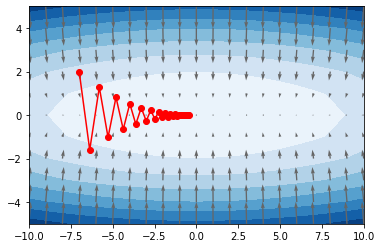

In [283]:
plt.contourf(X.reshape(11,21), Y.reshape(11,21), function(np.array([X, Y])).reshape(11,21), cmap='Blues');
plt.quiver(X, Y, -grad[0], -grad[1],  angles="xy",color="#666666");
plt.plot(x_hist[:,0], x_hist[:,1], 'o-', color='red');

#### Momentum
Momentumによる更新は以下のように表される。
$$
\boldsymbol{v} = \alpha\boldsymbol{v}-\eta\frac{\partial L}{\partial \boldsymbol{W}}\\
\boldsymbol{W} = \boldsymbol{W}+\boldsymbol{v}
$$

In [148]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                # vの初期値は0行列
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key] 
            params[key] += self.v[key]

In [233]:
x_hist = calc_hist(Momentum(lr=0.09), [-7.0, 2.0])

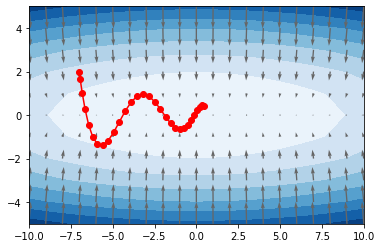

In [234]:
plt.contourf(X.reshape(11,21), Y.reshape(11,21), function(np.array([X, Y])).reshape(11,21), cmap='Blues');
plt.quiver(X, Y, -grad[0], -grad[1],  angles="xy",color="#666666");
plt.plot(x_hist[:,0], x_hist[:,1], 'o-', color='red');

#### Nesterov

In [277]:
class Nesterov:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
            
        for key in params.keys():
            params[key] += self.momentum * self.momentum * self.v[key]
            params[key] -= (1 + self.momentum) * self.lr * grads[key]
            self.v[key] *= self.momentum
            self.v[key] -= self.lr * grads[key]

In [298]:
x_hist = calc_hist(Nesterov(lr=0.08), [-7.0, 2.0])

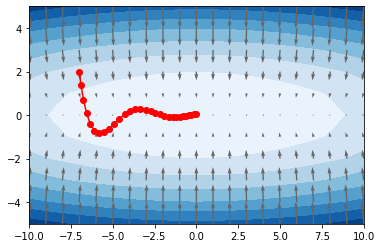

In [299]:
plt.contourf(X.reshape(11,21), Y.reshape(11,21), function(np.array([X, Y])).reshape(11,21), cmap='Blues');
plt.quiver(X, Y, -grad[0], -grad[1],  angles="xy",color="#666666");
plt.plot(x_hist[:,0], x_hist[:,1], 'o-', color='red');

#### Adagrad
学習係数は小さすぎると学習に時間がかかりすぎてしまい、大きすぎると発散して正しい学習が行えない。  
**学習係数の減衰(learning rate decay)**とは、学習が進むにつれて学習係数を小さくするという手法である。  
$$
\boldsymbol{h}=\boldsymbol{h}+\frac{\partial L}{\partial \boldsymbol{W}}\odot\frac{\partial L}{\partial \boldsymbol{W}}\\
\boldsymbol{W}=\boldsymbol{W}-\eta\frac{1}{\sqrt{\boldsymbol{h}}}\frac{\partial L}{\partial \boldsymbol{W}}
$$

In [182]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
    
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

In [235]:
x_hist = calc_hist(AdaGrad(lr=1.5), [-7.0, 2.0])

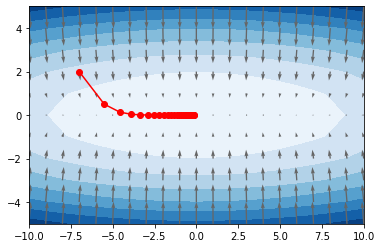

In [236]:
plt.contourf(X.reshape(11,21), Y.reshape(11,21), function(np.array([X, Y])).reshape(11,21), cmap='Blues');
plt.quiver(X, Y, -grad[0], -grad[1],  angles="xy",color="#666666");
plt.plot(x_hist[:,0], x_hist[:,1], 'o-', color='red');

#### RMSprop
RMSpropの更新式は以下のようになる。
$$
\boldsymbol{h}=\rho\boldsymbol{h}+(1-\rho)\frac{\partial L}{\partial \boldsymbol{W}}\odot\frac{\partial L}{\partial \boldsymbol{W}}\\
\boldsymbol{W}=\boldsymbol{W}-\eta\frac{1}{\sqrt{\boldsymbol{h}}}\frac{\partial L}{\partial \boldsymbol{W}}
$$

In [336]:
class RMSprop:
    def __init__(self, lr=0.01, decay_rate=0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
    
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

In [337]:
x_hist = calc_hist(RMSprop(lr=0.1), [-7.0, 2.0])

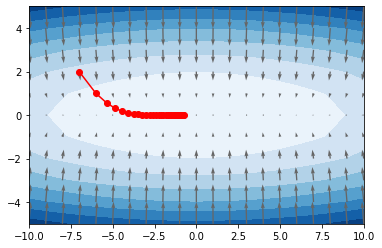

In [238]:
plt.contourf(X.reshape(11,21), Y.reshape(11,21), function(np.array([X, Y])).reshape(11,21), cmap='Blues');
plt.quiver(X, Y, -grad[0], -grad[1],  angles="xy",color="#666666");
plt.plot(x_hist[:,0], x_hist[:,1], 'o-', color='red');

#### Adam
Adamにおけるパラメータの更新、及びバイアスの補正は以下のようになる。
$$
\boldsymbol{m}=\rho_1\boldsymbol{m}+(1-\rho_1)\frac{\partial L}{\partial \boldsymbol{W}}\\
\boldsymbol{v}=\rho_2\boldsymbol{v}+(1-\rho_2)\frac{\partial L}{\partial \boldsymbol{W}}\odot\frac{\partial L}{\partial \boldsymbol{W}}\\
\hat{m}=\frac{m}{1-\rho_1}\\
\hat{v}=\frac{v}{1-\rho_2}\\
\boldsymbol{W}=\boldsymbol{W}-\eta\frac{1}{\sqrt{\boldsymbol{\hat{v}}}}\odot\boldsymbol{\hat{m}}
$$

In [1]:
class Adam:
    def __init__(self, lr=0.001, rho1=0.9, rho2=0.999):
        self.lr = lr
        self.rho1 = rho1
        self.rho2 = rho2
        self.iter = 0
        self.m = None
        self.v = None
        self.epsilon = 1e-8
    
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        
        for key in params.keys():
            self.m[key] = self.rho1*self.m[key] + (1-self.rho1)*grads[key]
            self.v[key] = self.rho2*self.v[key] + (1-self.rho2)*(grads[key]**2)
            m = self.m[key] / (1 - self.rho1**self.iter)
            v = self.v[key] / (1 - self.rho2**self.iter)
            
            params[key] -= self.lr * m / (np.sqrt(v) + self.epsilon)

In [239]:
x_hist = calc_hist(Adam(lr=0.3), [-7.0, 2.0])

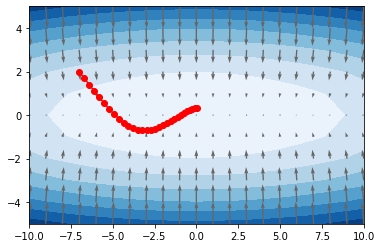

In [240]:
plt.contourf(X.reshape(11,21), Y.reshape(11,21), function(np.array([X, Y])).reshape(11,21), cmap='Blues');
plt.quiver(X, Y, -grad[0], -grad[1],  angles="xy",color="#666666");
plt.plot(x_hist[:,0], x_hist[:,1], 'o-', color='red');

### 重みの初期値
重みの初期値としてどのような値を設定するかで、学習の成否が分かれることがある。  
重みを小さく設定することで、過学習が起きにくくなる。

In [4]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def calc_a(std=1):
    x = np.random.randn(1000, 100)

    node_num = 100
    hidden_layer_size = 5
    activations = {}

    for i in range(hidden_layer_size):
        if i != 0:
            x = activations[i-1]
    
        w = np.random.randn(node_num, node_num) * std
    
        z = np.dot(x, w)
        a = sigmoid(z)
        activations[i] = a
    return activations

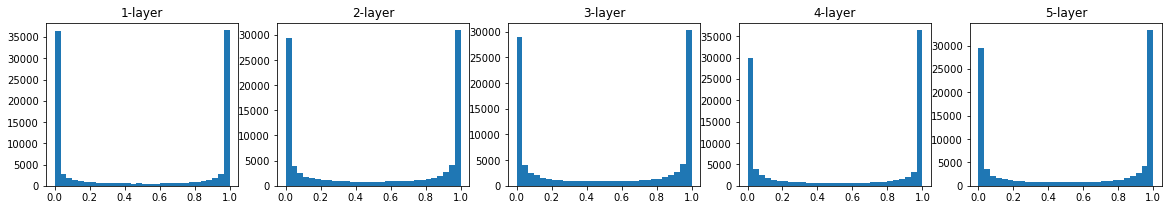

In [5]:
activations = calc_a(1)

plt.figure(figsize=(20, 3))
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

0と1に偏った分布になっていることがわかる。  
シグモイド関数の値が0または1に近づくにつれて、微分の値は0に近づく。  
そのため、逆伝播では勾配の値がどんどん小さくなって消えてしまう。これは**勾配消失**と呼ばれる問題である。  
  
次に重みの標準偏差を0.01として同じ計算を行ってみる。

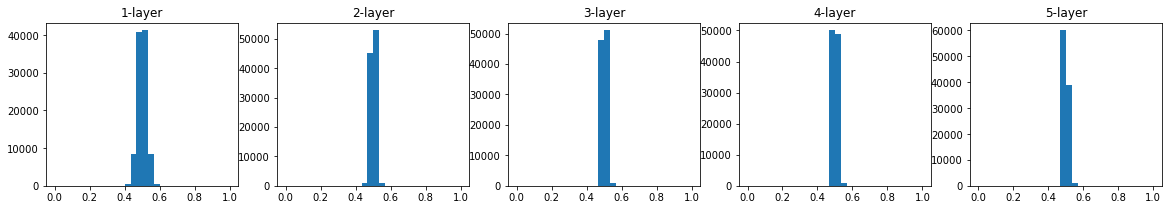

In [7]:
activations = calc_a(0.01)

plt.figure(figsize=(20, 3))
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

0と1への偏りはなくなったので勾配消失はおきないが、分布に偏りがあるため表現力の点で問題がある。

#### Xavierの初期値
sigmoid関数やtanhなどのS字カーブのときに使用される初期値  
前層のノードの個数を$n$とした場合、$\frac{1}{\sqrt{n}}$の標準偏差を持つ分布を使う方法

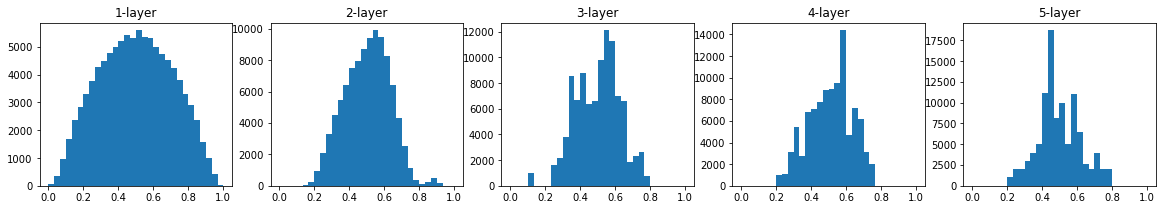

In [269]:
activations = calc_a(np.sqrt(1/node_num))

plt.figure(figsize=(20, 3))
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

#### Heの初期値
ReLuを使う場合に使用される初期値  
前層のノードの個数を$n$とした場合、$\sqrt{\frac{2}{n}}$の標準偏差を持つ分布を使う方法

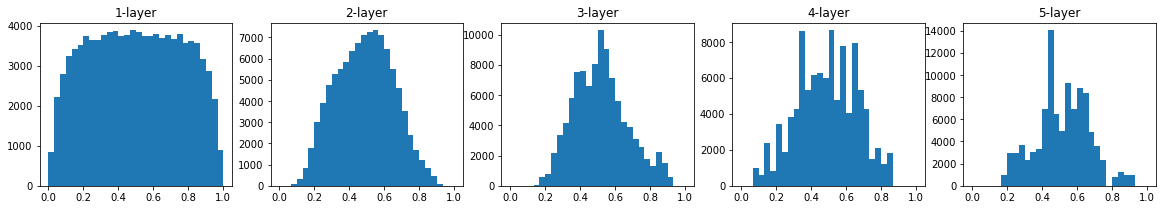

In [270]:
activations = calc_a(np.sqrt(2/node_num))

plt.figure(figsize=(20, 3))
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

### Batch Normalization
Batch Normalizationには以下のような利点がある。
- 学習を速く進行させることができる。
- 初期値にそれほど依存しない。
- 過学習を抑制する。

ミニバッチごとに正規化を行う。  
$$
\mu_{\beta}=\frac{1}{m}\sum_{i=1}^mx_i\\
\sigma^2_{B}=\frac{1}{m}\sum_{i=1}^m(x_i-\mu_{\beta})^2\\
\hat{x}_i=\frac{x_i-\mu_{\beta}}{\sqrt{\sigma^2_{B}+\epsilon}}
$$
さらに、固有のスケールとシフトで変換を行う。
$$
y_i=\gamma\hat{x}_i+\beta
$$

In [271]:
class BatchNormalization:
    """
    http://arxiv.org/abs/1502.03167
    """
    def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
        self.gamma = gamma
        self.beta = beta
        self.momentum = momentum
        self.input_shape = None # Conv層の場合は4次元、全結合層の場合は2次元  

        # テスト時に使用する平均と分散
        self.running_mean = running_mean
        self.running_var = running_var  
        
        # backward時に使用する中間データ
        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None

    def forward(self, x, train_flg=True):
        self.input_shape = x.shape
        if x.ndim != 2:
            N, C, H, W = x.shape
            x = x.reshape(N, -1)

        out = self.__forward(x, train_flg)
        
        return out.reshape(*self.input_shape)
            
    def __forward(self, x, train_flg):
        if self.running_mean is None:
            N, D = x.shape
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)
                        
        if train_flg:
            mu = x.mean(axis=0)
            xc = x - mu
            var = np.mean(xc**2, axis=0)
            std = np.sqrt(var + 10e-7)
            xn = xc / std
            
            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std
            self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1-self.momentum) * var            
        else:
            xc = x - self.running_mean
            xn = xc / ((np.sqrt(self.running_var + 10e-7)))
            
        out = self.gamma * xn + self.beta 
        return out

    def backward(self, dout):
        if dout.ndim != 2:
            N, C, H, W = dout.shape
            dout = dout.reshape(N, -1)

        dx = self.__backward(dout)

        dx = dx.reshape(*self.input_shape)
        return dx

    def __backward(self, dout):
        dbeta = dout.sum(axis=0)
        dgamma = np.sum(self.xn * dout, axis=0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / self.batch_size) * self.xc * dvar
        dmu = np.sum(dxc, axis=0)
        dx = dxc - dmu / self.batch_size
        
        self.dgamma = dgamma
        self.dbeta = dbeta
        
        return dx

### 正則化
過学習が起きる原因として、主に次の2つが挙げられる。
- パラメータを大量に持ち、表現力の高いモデルであること。
- 訓練データが少ないこと。


#### weight decay(荷重減衰)
学習の過程において、大きな重みをもつことに対してペナルティを課す手法。  
たとえば、L2ノルム$\frac{1}{2}\lambda\boldsymbol{W}^2$を損失関数に加算する。  
ここで、$\lambda$は正則化の強さをコントロールするハイパーパラメータである。  
誤差逆伝搬法では、正則化項の微分$\lambda\boldsymbol{W}$を加算する。  
  
たとえば、学習時損失を求める際は以下のように実装される。
```
def loss(self, x, t, train_flg=False):
    """損失関数を求める
    引数のxは入力データ、tは教師ラベル
    """
    y = self.predict(x, train_flg)

    weight_decay = 0
    for idx in range(1, self.hidden_layer_num + 2):
        W = self.params['W' + str(idx)]
        weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)

    return self.last_layer.forward(y, t) + weight_decay
```

また、勾配の計算は以下のように実装される。  
荷重減衰が行われるのは、$\boldsymbol{W}$のみである。
```
def gradient(self, x, t):
    # forward
    self.loss(x, t, train_flg=True)

    # backward
    dout = 1
    dout = self.last_layer.backward(dout)

    layers = list(self.layers.values())
    layers.reverse()
    for layer in layers:
        dout = layer.backward(dout)

    # 設定
    grads = {}
    for idx in range(1, self.hidden_layer_num+2):
        grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.params['W' + str(idx)]
        grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

        if self.use_batchnorm and idx != self.hidden_layer_num+1:
            grads['gamma' + str(idx)] = self.layers['BatchNorm' + str(idx)].dgamma
            grads['beta' + str(idx)] = self.layers['BatchNorm' + str(idx)].dbeta

    return grads
```

#### Dropout
Dropoutはニューロンをランダムに消去しながら学習する手法である。  
テスト時には、すべてのニューロンの信号を伝達するが、各ニューロンの出力に対して訓練時に消去した割合を乗算して出力する。

In [310]:
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
    
    def forward(self, x, train_flg=True):
        if train_flg:
            # self.dropout_ratioより大きい要素だけをTrueとする
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)
    
    def backward(self, dout):
        # 順伝搬で信号を通さなかったニューロンは、逆伝播では信号がそこでストップする
        return dout * self.mask

### 多層ニューラルネットワークの実装
上記の学習テクニックを加え、多層ニューラルネットワークの実装を行う。

In [301]:
from collections import OrderedDict

def softmax(x):
    x = x - np.max(x, axis=-1, keepdims=True)   # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx


class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx


class Affine:
    def __init__(self, W, b):
        self.W =W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 重み・バイアスパラメータの微分
        self.dW = None
        self.db = None

    def forward(self, x):
        # テンソル対応
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 入力データの形状に戻す（テンソル対応）
        return dx


class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None # softmaxの出力
        self.t = None # 教師データ

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 教師データがone-hot-vectorの場合
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx

In [275]:
class MultiLayerNetExtend:
    """拡張版の全結合による多層ニューラルネットワーク
    
    Weiht Decay、Dropout、Batch Normalizationの機能を持つ

    Parameters
    ----------
    input_size : 入力サイズ（MNISTの場合は784）
    hidden_size_list : 隠れ層のニューロンの数のリスト（e.g. [100, 100, 100]）
    output_size : 出力サイズ（MNISTの場合は10）
    activation : 'relu' or 'sigmoid'
    weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
        'relu'または'he'を指定した場合は「Heの初期値」を設定
        'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
    weight_decay_lambda : Weight Decay（L2ノルム）の強さ
    use_dropout: Dropoutを使用するかどうか
    dropout_ration : Dropoutの割り合い
    use_batchNorm: Batch Normalizationを使用するかどうか
    """
    def __init__(self, input_size, hidden_size_list, output_size,
                 activation='relu', weight_init_std='relu', weight_decay_lambda=0, 
                 use_dropout = False, dropout_ration = 0.5, use_batchnorm=False):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.use_dropout = use_dropout
        self.weight_decay_lambda = weight_decay_lambda
        self.use_batchnorm = use_batchnorm
        self.params = {}

        # 重みの初期化
        self.__init_weight(weight_init_std)

        # レイヤの生成
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num+1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
                                                      self.params['b' + str(idx)])
            # Batch Normalization
            if self.use_batchnorm:
                self.params['gamma' + str(idx)] = np.ones(hidden_size_list[idx-1])
                self.params['beta' + str(idx)] = np.zeros(hidden_size_list[idx-1])
                self.layers['BatchNorm' + str(idx)] = BatchNormalization(self.params['gamma' + str(idx)], self.params['beta' + str(idx)])
                
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()
            
            # Dropout
            if self.use_dropout:
                self.layers['Dropout' + str(idx)] = Dropout(dropout_ration)

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithLoss()

    def __init_weight(self, weight_init_std):
        """重みの初期値設定

        Parameters
        ----------
        weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
            'relu'または'he'を指定した場合は「Heの初期値」を設定
            'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
        """
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            # Heの初期値
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])  # ReLUを使う場合に推奨される初期値
            # Xavierの初期値
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # sigmoidを使う場合に推奨される初期値
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x, train_flg=False):
        for key, layer in self.layers.items():
            if "Dropout" in key or "BatchNorm" in key:
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)

        return x

    def loss(self, x, t, train_flg=False):
        """損失関数を求める
        引数のxは入力データ、tは教師ラベル
        """
        y = self.predict(x, train_flg)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            # weight decayの算出
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)

        return self.last_layer.forward(y, t) + weight_decay

    def accuracy(self, x, t):
        y = self.predict(x, train_flg=False)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def numerical_gradient(self, x, t):
        """勾配を求める（数値微分）

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        loss_W = lambda W: self.loss(x, t, train_flg=True)

        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = numerical_gradient(loss_W, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_W, self.params['b' + str(idx)])
            
            if self.use_batchnorm and idx != self.hidden_layer_num+1:
                grads['gamma' + str(idx)] = numerical_gradient(loss_W, self.params['gamma' + str(idx)])
                grads['beta' + str(idx)] = numerical_gradient(loss_W, self.params['beta' + str(idx)])

        return grads
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t, train_flg=True)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            # weight decayはWのみ
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.params['W' + str(idx)]
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

            if self.use_batchnorm and idx != self.hidden_layer_num+1:
                grads['gamma' + str(idx)] = self.layers['BatchNorm' + str(idx)].dgamma
                grads['beta' + str(idx)] = self.layers['BatchNorm' + str(idx)].dbeta

        return grads

In [276]:
import numpy as np
from sklearn import preprocessing
import pickle
from sklearn.model_selection import train_test_split

with open('mnist.pkl', 'rb') as f:
    X, y = pickle.load(f)

X = np.array(X) / 255.0

lb = preprocessing.LabelBinarizer()
y = lb.fit_transform(y)

x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [327]:
network = MultiLayerNetExtend(input_size=784, hidden_size_list=[300, 100, 50], output_size=10,
                              weight_decay_lambda=0, use_dropout = False, dropout_ration = 0.5, use_batchnorm=False)
optimizer = SGD(lr=0.01)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(10000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = y_train[batch_mask]
    
    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, y_train)
        test_acc = network.accuracy(x_test, y_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break

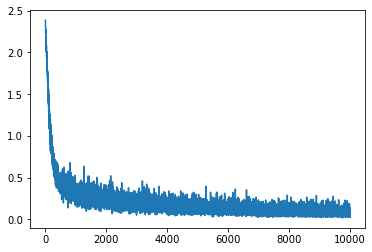

In [328]:
plt.plot(train_loss_list)

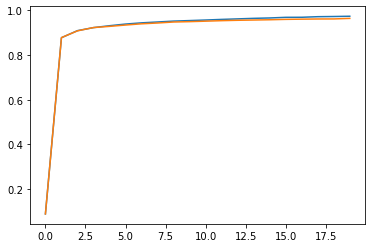

In [329]:
plt.plot(train_acc_list)
plt.plot(test_acc_list)

#### Trainreクラスの定義

In [330]:
class Trainer:
    """ニューラルネットの訓練を行うクラス
    """
    def __init__(self, network, x_train, t_train, x_test, t_test,
                 epochs=20, mini_batch_size=100,
                 optimizer='SGD', optimizer_param={'lr':0.01}, 
                 evaluate_sample_num_per_epoch=None, verbose=True):
        self.network = network
        self.verbose = verbose
        self.x_train = x_train
        self.t_train = t_train
        self.x_test = x_test
        self.t_test = t_test
        self.epochs = epochs
        self.batch_size = mini_batch_size
        self.evaluate_sample_num_per_epoch = evaluate_sample_num_per_epoch

        # optimizer
        optimizer_class_dict = {'sgd':SGD, 'momentum':Momentum, 'nesterov':Nesterov,
                                'adagrad':AdaGrad, 'rmsprop':RMSprop, 'adam':Adam}
        self.optimizer = optimizer_class_dict[optimizer.lower()](**optimizer_param)
        
        self.train_size = x_train.shape[0]
        self.iter_per_epoch = max(self.train_size / mini_batch_size, 1)
        self.max_iter = int(epochs * self.iter_per_epoch)
        self.current_iter = 0
        self.current_epoch = 0
        
        self.train_loss_list = []
        self.train_acc_list = []
        self.test_acc_list = []

    def train_step(self):
        batch_mask = np.random.choice(self.train_size, self.batch_size)
        x_batch = self.x_train[batch_mask]
        t_batch = self.t_train[batch_mask]
        
        grads = self.network.gradient(x_batch, t_batch)
        self.optimizer.update(self.network.params, grads)
        
        loss = self.network.loss(x_batch, t_batch)
        self.train_loss_list.append(loss)
        if self.verbose: print("train loss:" + str(loss))
        
        if self.current_iter % self.iter_per_epoch == 0:
            self.current_epoch += 1
            
            x_train_sample, t_train_sample = self.x_train, self.t_train
            x_test_sample, t_test_sample = self.x_test, self.t_test
            if not self.evaluate_sample_num_per_epoch is None:
                t = self.evaluate_sample_num_per_epoch
                x_train_sample, t_train_sample = self.x_train[:t], self.t_train[:t]
                x_test_sample, t_test_sample = self.x_test[:t], self.t_test[:t]
                
            train_acc = self.network.accuracy(x_train_sample, t_train_sample)
            test_acc = self.network.accuracy(x_test_sample, t_test_sample)
            self.train_acc_list.append(train_acc)
            self.test_acc_list.append(test_acc)

            if self.verbose: print("=== epoch:" + str(self.current_epoch) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc) + " ===")
        self.current_iter += 1

    def train(self):
        for i in range(self.max_iter):
            self.train_step()

        test_acc = self.network.accuracy(self.x_test, self.t_test)

        if self.verbose:
            print("=============== Final Test Accuracy ===============")
            print("test acc:" + str(test_acc))

In [341]:
def __train(lr, weight_decay, epocs=10):
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[200, 50],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, y_train, x_test, y_test,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list, trainer.train_loss_list

In [342]:
val_acc_list, train_acc_list, train_loss_list = __train(lr=0.01, weight_decay=0.1)

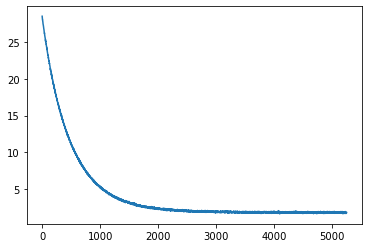

In [343]:
plt.plot(train_loss_list)

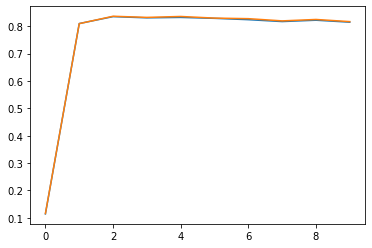

In [346]:
plt.plot(train_acc_list)
plt.plot(val_acc_list)